In [22]:
import math
import dltools
import torch
from torch import nn
batch_size,max_window_size,num_noise_words = 512,5,5
data_iter,vocab = dltools.load_data_ptb(batch_size,max_window_size,num_noise_words)

In [23]:
for batch in data_iter:
    break

batch

(tensor([[1871],
         [ 340],
         [1784],
         [  26],
         [ 995],
         [ 623],
         [ 184],
         [ 994],
         [1187],
         [ 821],
         [1495],
         [2373],
         [ 702],
         [ 361],
         [  23],
         [1571],
         [  51],
         [1120],
         [ 952],
         [   6],
         [ 481],
         [  14],
         [4489],
         [1402],
         [1388],
         [6029],
         [ 116],
         [1555],
         [ 651],
         [5332],
         [ 917],
         [2434],
         [  15],
         [3120],
         [1059],
         [   2],
         [3430],
         [ 800],
         [  22],
         [ 114],
         [4294],
         [  75],
         [  11],
         [4753],
         [2224],
         [ 961],
         [ 903],
         [ 108],
         [2937],
         [ 788],
         [  26],
         [1103],
         [   0],
         [  77],
         [ 864],
         [4076],
         [ 802],
         [ 235],
         [3887

In [24]:
embed = nn.Embedding(num_embeddings=20,embedding_dim=4)


In [25]:
embed.weight.shape

torch.Size([20, 4])

In [26]:
x = torch.tensor([[1,2,3],[4,5,6]])
result = embed(x)
result.shape

torch.Size([2, 3, 4])

In [27]:
def skip_gram(center,context_and_negatives,embed_v,embed_u):
    v = embed_v(center)
    u = embed_u(context_and_negatives)
    pred = torch.bmm(v,u.permute(0,2,1))
    return pred

In [32]:
class SigmoidBCELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,input,target,mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(input,target,weight=mask,reduction='none')
        return out.mean(dim=1)

In [29]:
embed_size =100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),embedding_dim=embed_size),nn.Embedding(num_embeddings=len(vocab),embedding_dim=embed_size))

In [30]:
def train(net,data_iter,lr,num_epochs,device = dltools.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    loss = SigmoidBCELoss()
    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    animator = dltools.Animator(xlabel='epoch',ylabel="loss",xlim=[1,num_epochs])
    metric = dltools.Accumulator(2)
    for epochs in range(num_epochs):
        timer,num_batches = dltools.Timer(),len(data_iter)
        for i ,batch in enumerate(data_iter):
            optimizer.zero_grad()
            center,context_and_negative,mask,label = [data.to(device) for data in batch]
            pred = skip_gram(center,context_and_negative,net[0],net[1])
            l =( loss(pred.reshape(label.shape).float(),label.float(),mask)/mask.sum(axis=1)*mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(),l.numel())
            if (i+1)%(num_batches//5) ==0 or i == num_batches -1:
                animator.add(epochs + (i+1)/num_batches,metric[0]/metric[1])
    print(f'loss{metric[0]/metric[1]: .3f}',f'{metric[1]/timer.stop(): . 1f} tokens/sec on {str(device)}')

ValueError: Format specifier missing precision

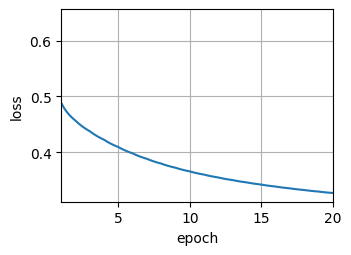

In [34]:
lr,num_epoches = 0.002,20
train(net,data_iter,lr,num_epoches)